In [ ]:
from dotenv import load_dotenv
import os
import re
from huggingface_hub import login, snapshot_download
from PIL import Image, ImageDraw, ImageFont

In [ ]:
load_dotenv()

In [53]:
login(token=os.getenv("HF_API_TOKEN"))

In [ ]:
# download the dataset repository locally
snapshot_download(
    repo_id="vcog/vcog-bench",
    repo_type="dataset",
    local_dir="../data_raw/vcog-bench",
)

print("Dataset downloaded to ../data_raw/vcog-bench")

# old

#### generating questions sheets cvr + marsvqa

In [ ]:
def generate_question_sheet_from_images_cvr(
    images, label_font_size=40, spacing=30, margin=20, question_image=None, border_thickness=2
):
    max_height = max(img.height for img in images)
    resized_images = []
    for img in images:
        if img.height != max_height:
            ratio = max_height / img.height
            new_width = int(img.width * ratio)
            img = img.resize((new_width, max_height))
        resized_images.append(img)

    total_width = sum(img.width for img in resized_images) + spacing * (len(resized_images)-1)
    total_height = max_height + label_font_size + 10

    question_img_height = 0
    if question_image:
        question_img_height = question_image.height + spacing
        total_height += question_img_height

    sheet = Image.new('RGB', (total_width + 2*margin, total_height + 2*margin), color=(255,255,255))

    try:
        font = ImageFont.truetype("arial.ttf", label_font_size) # type: ignore
    except:
        font = ImageFont.load_default()

    draw = ImageDraw.Draw(sheet)

    y_offset = margin
    if question_image:

        x_center = margin + (total_width - question_image.width) // 2
        sheet.paste(question_image, (x_center, y_offset))

        draw.rectangle(
            [x_center, y_offset, x_center + question_image.width - 1, y_offset + question_image.height - 1],
            outline="black", width=border_thickness
        )
        y_offset += question_img_height

    x_offset = margin
    labels = ['A','B','C','D']

    for i, img in enumerate(resized_images):
        bbox = draw.textbbox((0,0), labels[i], font=font)
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        draw.text((x_offset + (img.width - w)//2, y_offset), labels[i], fill='black', font=font)
        sheet.paste(img, (x_offset, y_offset + label_font_size + 10))

        draw.rectangle(
            [x_offset, y_offset + label_font_size + 10, x_offset + img.width - 1, y_offset + label_font_size + 10 + img.height - 1],
            outline="black", width=border_thickness
        )
        x_offset += img.width + spacing

    display(sheet)
    return sheet


## cvr

#### checking if all answers are in 4th position - CONFIRMED

In [ ]:
base_dir = "../data_raw/vcog-bench/cvr"
pattern = re.compile(r"sub_image_(\d+)\.png")

mismatches = []

for i in range(309): 
    example_dir = os.path.join(base_dir, str(i), "answer", "image")
    
    if not os.path.exists(example_dir):
        mismatches.append((i, "MISSING answer/image directory"))
        continue
    
    files = os.listdir(example_dir)
    png_files = [f for f in files if f.endswith(".png")]
    
    if len(png_files) == 0:
        mismatches.append((i, "NO PNG in answer/image"))
        continue
    if len(png_files) > 1:
        mismatches.append((i, f"MULTIPLE PNGs: {png_files}"))
        continue
    
    file_name = png_files[0]
    match = pattern.match(file_name)
    
    if not match:
        mismatches.append((i, f"BAD FILE NAME: {file_name}"))
        continue
    
    image_number = match.group(1)
    print(f"Example {i} → image number {image_number}")


Example 0 → image number 4
Example 1 → image number 4
Example 2 → image number 4
Example 3 → image number 4
Example 4 → image number 4
Example 5 → image number 4
Example 6 → image number 4
Example 7 → image number 4
Example 8 → image number 4
Example 9 → image number 4
Example 10 → image number 4
Example 11 → image number 4
Example 12 → image number 4
Example 13 → image number 4
Example 14 → image number 4
Example 15 → image number 4
Example 16 → image number 4
Example 17 → image number 4
Example 18 → image number 4
Example 19 → image number 4
Example 20 → image number 4
Example 21 → image number 4
Example 22 → image number 4
Example 23 → image number 4
Example 24 → image number 4
Example 25 → image number 4
Example 26 → image number 4
Example 27 → image number 4
Example 28 → image number 4
Example 29 → image number 4
Example 30 → image number 4
Example 31 → image number 4
Example 32 → image number 4
Example 33 → image number 4
Example 34 → image number 4
Example 35 → image number 4
Ex

#### old- loading dataset to a variable

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt
cvr_dataset = load_dataset("vcog/vcog-bench", data_dir = "cvr")


Resolving data files:   0%|          | 0/1545 [00:00<?, ?it/s]

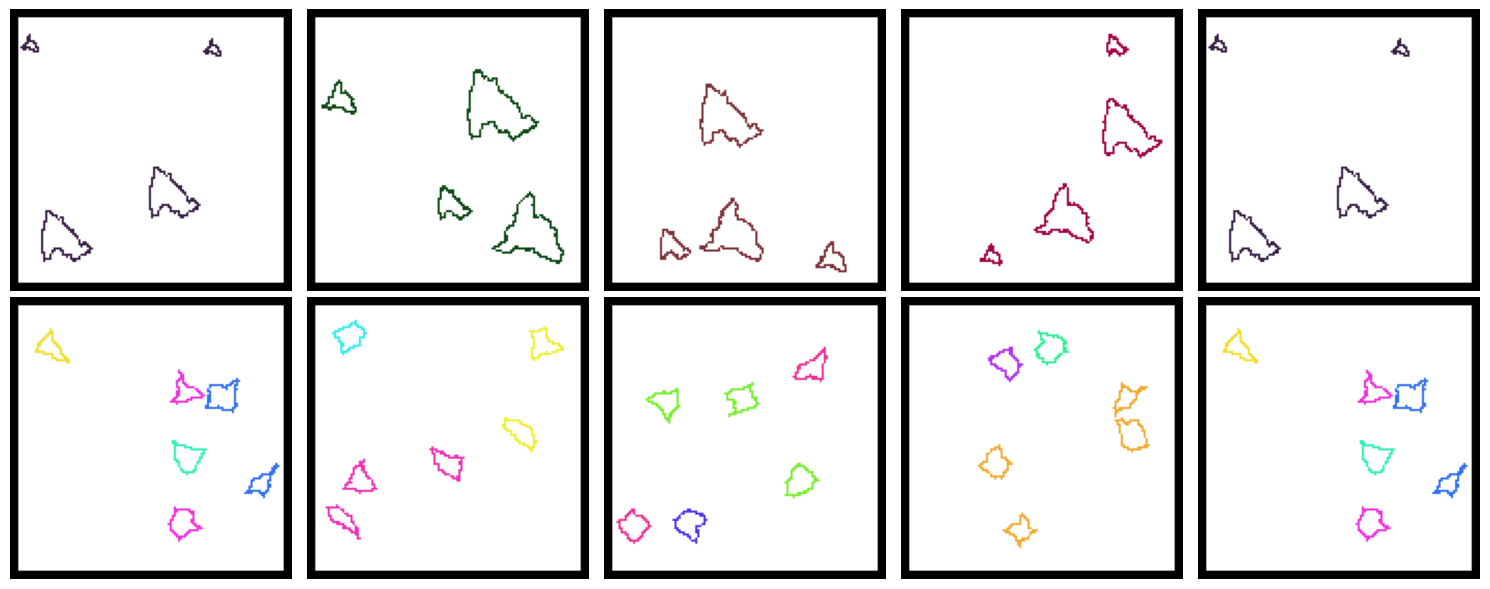

In [3]:
import matplotlib.pyplot as plt
import math

def display_first_images(dataset, num_images=5, max_per_row=5):
    """Display the first `num_images` images from the dataset in rows of up to `max_per_row`."""
    rows = math.ceil(num_images / max_per_row)
    cols = min(num_images, max_per_row)

    fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    axes = axes.flatten() if rows > 1 else axes  # spłaszczenie tablicy osi

    for i in range(num_images):
        image = dataset['train'][i]['image']
        axes[i].imshow(image)
        axes[i].axis('off')

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_first_images(cvr_dataset, num_images=10, max_per_row=5)


In [ ]:
import random

indices = [1, 2, 3, 4]
images = []

for idx in indices:
    img = cvr_dataset['train'][idx]['image'] 
    images.append(img.convert("RGB"))

image, answer, shuffle_indices = generate_question_sheet_from_images(images, shuffle_answers=True, true_answer_index=3)
print("Answer:", answer)
print("Shuffle Indices:", shuffle_indices)

image.show()

Answer: B


## marsvqa

#### checking if all answers are the first image - CONFIRMED


In [80]:
import os
import re

base_dir = "../data_raw/vcog-bench/marsvqa"
# Regex: find digits after "_T"
pattern = re.compile(r"_T(\d+)_")

mismatches = []

for i in range(480):  
    example_dir = os.path.join(base_dir, str(i), "answer", "image")
    
    if not os.path.exists(example_dir):
        mismatches.append((i, "MISSING answer/image directory"))
        continue
    
    files = [f for f in os.listdir(example_dir) if f.endswith(".jpeg")]
    
    if len(files) == 0:
        mismatches.append((i, "NO JPEG in answer/image"))
        continue
    if len(files) > 1:
        mismatches.append((i, f"MULTIPLE JPEGs: {files}"))
        continue
    
    file_name = files[0]
    match = pattern.search(file_name)
    
    if not match:
        mismatches.append((i, f"BAD FILE NAME: {file_name}"))
        continue
    
    image_number = match.group(1)
    
    # Log result
    print(f"Example {i} → image number {image_number}")



Example 0 → image number 1
Example 1 → image number 1
Example 2 → image number 1
Example 3 → image number 1
Example 4 → image number 1
Example 5 → image number 1
Example 6 → image number 1
Example 7 → image number 1
Example 8 → image number 1
Example 9 → image number 1
Example 10 → image number 1
Example 11 → image number 1
Example 12 → image number 1
Example 13 → image number 1
Example 14 → image number 1
Example 15 → image number 1
Example 16 → image number 1
Example 17 → image number 1
Example 18 → image number 1
Example 19 → image number 1
Example 20 → image number 1
Example 21 → image number 1
Example 22 → image number 1
Example 23 → image number 1
Example 24 → image number 1
Example 25 → image number 1
Example 26 → image number 1
Example 27 → image number 1
Example 28 → image number 1
Example 29 → image number 1
Example 30 → image number 1
Example 31 → image number 1
Example 32 → image number 1
Example 33 → image number 1
Example 34 → image number 1
Example 35 → image number 1
Ex

#### old - loading data to variable

In [7]:
marsvqa_dataset = load_dataset("vcog/vcog-bench", data_dir="marsvqa")


Resolving data files:   0%|          | 0/5280 [00:00<?, ?it/s]

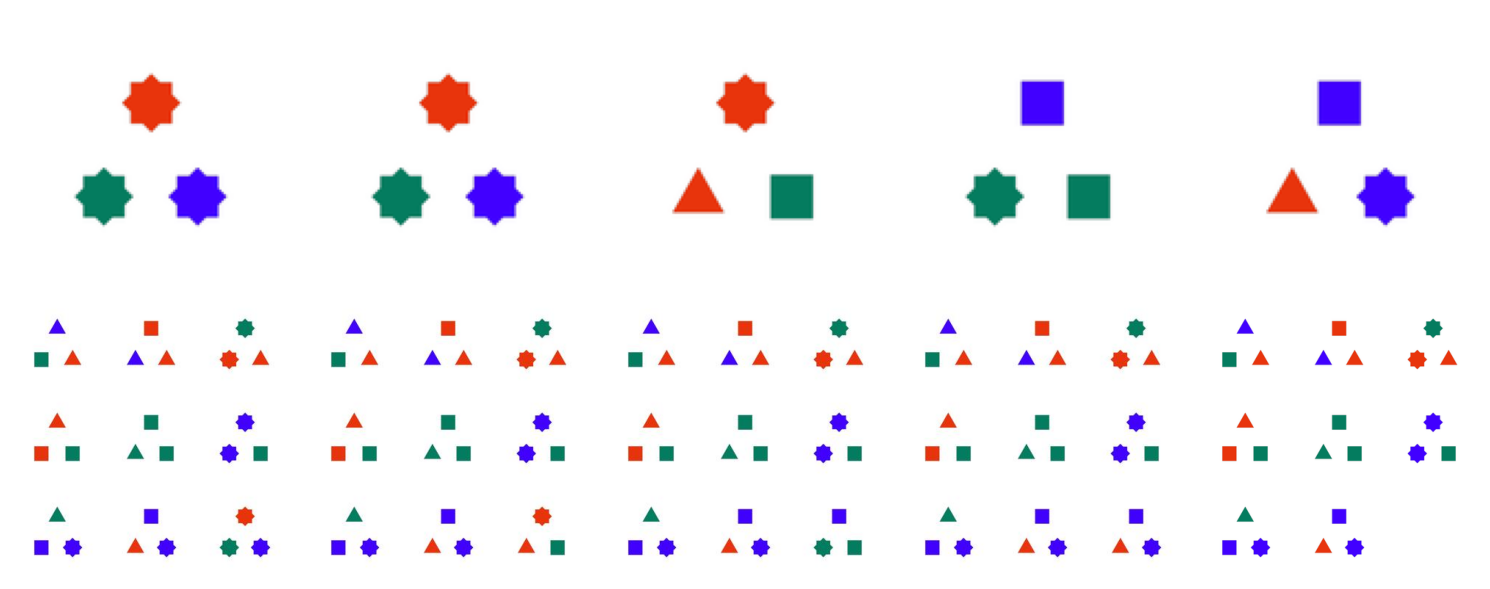

In [8]:

#[0] - answer
#[9] - questions
#[1-4] - options
#[5-8] - options in whole
#[10] ...
display_first_images(marsvqa_dataset, num_images=10)

In [8]:
indices = [1, 2, 3, 4]
images = []

for idx in indices:
    img = marsvqa_dataset['train'][idx]['image'] 
    images.append(img.convert("RGB"))

image = generate_question_sheet_from_images_cvr(images, question_image=marsvqa_dataset['train'][9]['image'])

NameError: name 'marsvqa_dataset' is not defined

# wnioski z old:
- ładujemy dane na komputer i przerabiamy lokalnie bo tak będzie łatwiej a tych danych nie ma nie wiadomo jak dużo  
- dla cvr i marvqa trzeba zrobić shuffling, bo dla cvr zawsze poprawna jest ostatnia a dla marsvqa pierwsza odpowiedź

# new

## bongard

#### processing data for direct approach

In [ ]:
def generate_question_sheet_two_panels_no_labels(
    images, spacing=10, margin=20, border_thickness=2, space_between_panels=40
):
    """
    Generates a question sheet with two panels (left & right), each with 2 columns of 3 images (total 6 per panel),
    with borders, no labels.

    Args:
        images (list of PIL.Image): List of 12 images.
        spacing (int): Space between images and columns.
        margin (int): Margin around the sheet.
        border_thickness (int): Thickness of the borders around images.
        space_between_panels (int): Space between the two panels.
    Returns:
        PIL.Image: Generated question sheet.
    """

    if len(images) != 12:
        raise ValueError("Exactly 12 images are required (0-11).")

    max_width = max(img.width for img in images)
    resized_images = []
    for img in images:
        if img.width != max_width:
            ratio = max_width / img.width
            new_height = int(img.height * ratio)
            img = img.resize((max_width, new_height))
        resized_images.append(img)

    panels = [resized_images[:6], resized_images[6:]]

    col_width = max(img.width for img in images[:6])

    row_heights = []
    for col in range(2):
        row_heights_col = [panels[0][col*3 + r].height for r in range(3)]
        row_heights.append(row_heights_col)

    total_width = col_width*4 + spacing*3 + space_between_panels  # 2 columns per panel + spacing + panel gap
    total_height = max(
        sum([panels[0][col*3 + r].height for r in range(3)] + [panels[1][col*3 + r].height for r in range(3)]) 
        for col in range(2)
    ) + 2*margin

    sheet = Image.new('RGB', (total_width + 2*margin, total_height + 2*margin), color=(255, 255, 255))
    draw = ImageDraw.Draw(sheet)

    x_offset = margin
    y_offset = margin

    for panel_idx, panel in enumerate(panels):
        for col in range(2):
            y_pos = margin
            for row in range(3):
                img_idx = col*3 + row
                img = panel[img_idx]

                sheet.paste(img, (x_offset, y_pos))

                draw.rectangle(
                    [x_offset, y_pos, x_offset + img.width - 1, y_pos + img.height - 1],
                    outline="black", width=border_thickness
                )

                y_pos += img.height + spacing

            x_offset += col_width + spacing

        if panel_idx == 0:
            x_offset += space_between_panels - spacing

    return sheet


In [ ]:
bp_images_path = "../data_raw/bp"
bp_output_path = "../data/direct/bp/images"

os.makedirs(bp_output_path, exist_ok=True)
folders = sorted(os.listdir(bp_images_path))

for folder in folders:
    input_folder = os.path.join(bp_images_path, folder)
    
    if not os.path.isdir(input_folder):
        continue

    bp_images = []
    img_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".png")],
                       key=lambda x: int(os.path.splitext(x)[0]))
    
    for img_file in img_files:
        img_path = os.path.join(input_folder, img_file)
        img = Image.open(img_path).convert("RGB")
        bp_images.append(img)
    
    sheet = generate_question_sheet_two_panels_no_labels(bp_images)

    output_path = os.path.join(bp_output_path, f"{folder}.png")
    sheet.save(output_path)
    
    print(f"Saved sheet for folder {folder} → {output_path}")

print("✅ All examples processed.")


## marsvqa + cvr

### helper functions

In [ ]:
def generate_question_sheet_from_images(
    images, label_font_size=40, spacing=30, margin=20, question_image=None, border_thickness=2
):
    max_height = max(img.height for img in images)
    resized_images = []
    for img in images:
        if img.height != max_height:
            ratio = max_height / img.height
            new_width = int(img.width * ratio)
            img = img.resize((new_width, max_height))
        resized_images.append(img)

    total_width = sum(img.width for img in resized_images) + spacing * (len(resized_images)-1)
    total_height = max_height + label_font_size + 10

    question_img_height = 0
    if question_image:
        # keep original resolution, just add its height
        question_img_height = question_image.height + spacing
        total_height += question_img_height

    # create sheet with margin
    sheet = Image.new('RGB', (total_width + 2*margin, total_height + 2*margin), color=(255,255,255))

    try:
        font = ImageFont.truetype("arial.ttf", label_font_size) # type: ignore
    except:
        font = ImageFont.load_default()

    draw = ImageDraw.Draw(sheet)

    y_offset = margin
    if question_image:
        # center question image without resizing
        x_center = margin + (total_width - question_image.width) // 2
        sheet.paste(question_image, (x_center, y_offset))
        # border around question image
        draw.rectangle(
            [x_center, y_offset, x_center + question_image.width - 1, y_offset + question_image.height - 1],
            outline="black", width=border_thickness
        )
        y_offset += question_img_height

    x_offset = margin
    labels = ['A','B','C','D']

    for i, img in enumerate(resized_images):
        bbox = draw.textbbox((0,0), labels[i], font=font)
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        draw.text((x_offset + (img.width - w)//2, y_offset), labels[i], fill='black', font=font)
        sheet.paste(img, (x_offset, y_offset + label_font_size + 10))
        # draw border around answer image
        draw.rectangle(
            [x_offset, y_offset + label_font_size + 10, x_offset + img.width - 1, y_offset + label_font_size + 10 + img.height - 1],
            outline="black", width=border_thickness
        )
        x_offset += img.width + spacing

    display(sheet)
    return sheet


In [7]:
import random
random.seed(42)

import os
from PIL import Image, ImageDraw, ImageFont
def generate_question_sheet_from_images(
        images, label_font_size=40, spacing=30, margin=20, question_image=None, border_thickness=2, shuffle_answers=False, true_answer_index=None):
        if shuffle_answers:
            if true_answer_index is None or not (0 <= true_answer_index < len(images)):
                raise ValueError("true_answer_index must be provided and valid when shuffle_answers is True.")
            indices = list(range(len(images)))
            random.shuffle(indices)
            shuffled_images = [images[i] for i in indices]
            answer_label = chr(ord('A') + indices.index(true_answer_index))
            images = shuffled_images

        max_height = max(img.height for img in images)
        resized_images = []
        for img in images:
            if img.height != max_height:
                ratio = max_height / img.height
                new_width = int(img.width * ratio)
                img = img.resize((new_width, max_height))
            resized_images.append(img)

        total_width = sum(img.width for img in resized_images) + spacing * (len(resized_images)-1)
        total_height = max_height + label_font_size + 10

        question_img_height = 0
        if question_image:
            # keep original resolution, just add its height
            question_img_height = question_image.height + spacing
            total_height += question_img_height

        # create sheet with margin
        sheet = Image.new('RGB', (total_width + 2*margin, total_height + 2*margin), color=(255,255,255))

        try:
            font = ImageFont.truetype("arial.ttf", label_font_size) # type: ignore
        except:
            font = ImageFont.load_default()

        draw = ImageDraw.Draw(sheet)

        y_offset = margin
        if question_image:
            # center question image without resizing
            x_center = margin + (total_width - question_image.width) // 2
            sheet.paste(question_image, (x_center, y_offset))
            # border around question image
            draw.rectangle(
                [x_center, y_offset, x_center + question_image.width - 1, y_offset + question_image.height - 1],
                outline="black", width=border_thickness
            )
            y_offset += question_img_height

        x_offset = margin
        labels = ['A','B','C','D']

        for i, img in enumerate(resized_images):
            bbox = draw.textbbox((0,0), labels[i], font=font)
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            draw.text((x_offset + (img.width - w)//2, y_offset), labels[i], fill='black', font=font)
            sheet.paste(img, (x_offset, y_offset + label_font_size + 10))
            # draw border around answer image
            draw.rectangle(
                [x_offset, y_offset + label_font_size + 10, x_offset + img.width - 1, y_offset + label_font_size + 10 + img.height - 1],
                outline="black", width=border_thickness
            )
            x_offset += img.width + spacing

        return sheet, answer_label
    

### cvr

### marsvqa